In [2]:
!pip install ffmpeg-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""


def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [4]:
audio, sr = get_audio()

In [5]:
import scipy
scipy.io.wavfile.write('recording.wav', sr, audio)

In [6]:
audio

array([0, 0, 0, ..., 0, 0, 0], dtype=int16)

In [7]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

y, sr = librosa.load('recording.wav')

In [8]:
S = np.abs(librosa.stft(y))

In [9]:
S

array([[0.0000000e+00, 5.1520728e-05, 6.1645184e-04, ..., 7.9252553e-04,
        3.7592712e-03, 6.7239278e-03],
       [0.0000000e+00, 5.1314146e-05, 6.0281699e-04, ..., 4.0762778e-04,
        3.4224063e-03, 4.4017890e-03],
       [0.0000000e+00, 5.0727984e-05, 5.3586508e-04, ..., 6.7401043e-04,
        2.2538796e-03, 5.5132207e-04],
       ...,
       [0.0000000e+00, 6.7653478e-09, 4.7513499e-08, ..., 5.1639586e-07,
        1.1196779e-06, 1.2632313e-06],
       [0.0000000e+00, 6.8154251e-09, 9.1068962e-08, ..., 6.9560150e-07,
        1.6730614e-06, 2.6457303e-06],
       [0.0000000e+00, 6.8246222e-09, 1.1453262e-07, ..., 3.8385198e-07,
        1.3698678e-06, 2.9876639e-06]], dtype=float32)

In [10]:
S_left = librosa.stft(y, center=False)

In [11]:
D_short = librosa.stft(y, hop_length=64)

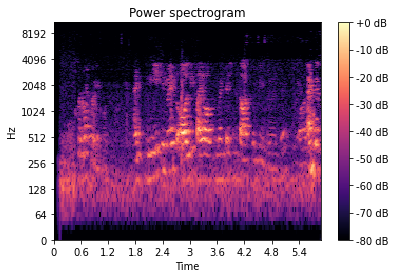

In [12]:
import matplotlib.pyplot as plt
from librosa import display

fig, ax = plt.subplots()
img = display.specshow(librosa.amplitude_to_db(S,ref=np.max),y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")